In [112]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [113]:
# load data
last = pd.read_csv('data_last.csv')
mkt_cap = pd.read_csv('data_mkt_cap.csv')
sector = pd.read_csv('data_sector.csv')
volume = pd.read_csv('data_volume.csv')


# merge data
lastAndMarketCap = last.merge(mkt_cap, left_on=['date', 'ticker'], right_on=['date', 'ticker'], how='inner')
full = lastAndMarketCap.merge(volume, left_on=['date', 'ticker'], right_on=['date', 'ticker'], how='inner')
full = full.merge(sector, left_on=['ticker'], right_on=['ticker'], how='inner')
full

,ticker,date,last,mkt_cap,volume,bics_sector
0,1332 JT,2017-08-16,562.12,199642.95,1641300.0,"Consumer, Non-cyclical"
1,1332 JT,2017-08-17,560.36,199018.09,1247700.0,"Consumer, Non-cyclical"
2,1332 JT,2017-08-18,553.32,196518.64,1505800.0,"Consumer, Non-cyclical"
3,1332 JT,2017-08-21,544.53,193394.34,2046200.0,"Consumer, Non-cyclical"
4,1332 JT,2017-08-22,535.73,190270.04,2409300.0,"Consumer, Non-cyclical"
...,...,...,...,...,...,...
420532,9984 JT,2024-02-29,8790.00,12921258.07,10544100.0,Communications
420533,9984 JT,2024-03-01,8907.00,13093247.51,12555200.0,Communications
420534,9984 JT,2024-03-04,8934.00,13132937.38,12317400.0,Communications
420535,9984 JT,2024-03-05,9008.00,13241717.03,10072900.0,Communications


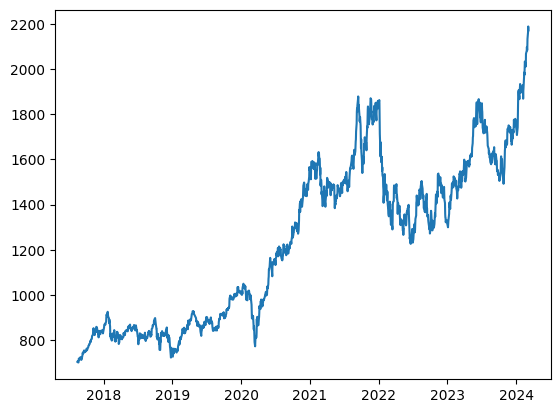

In [114]:
# calculate the stock index
full["weight"] = full["mkt_cap"] / full.groupby("date")["mkt_cap"].transform("sum")
new_stock_index = full.groupby("date").apply(lambda x: np.sum(x["last"]*x["weight"]))

new_stock_index = pd.DataFrame(new_stock_index, columns=["last"])
new_stock_index["date"] = new_stock_index.index
new_stock_index.index = range(len(new_stock_index))

# normalize the stock index
last_on_2020_01_06 = float(new_stock_index[new_stock_index["date"] == "2020-01-06"]["last"])
new_stock_index["last"] = new_stock_index["last"] / last_on_2020_01_06 * 1000

# plot the stock index
new_stock_index["date"] = pd.to_datetime(new_stock_index["date"], format='%Y-%m-%d')
fig, ax = plt.subplots()
ax.plot(new_stock_index["date"], new_stock_index["last"])
plt.show()

In [115]:
# find the top 5 and bottom 5 stocks of each day

# select the data of 2021-01
full["diff"] = full.groupby("ticker")["last"].diff()
full_2021_01 = full[full["date"] >= "2021-01-01"]
full_2021_01 = full_2021_01[full_2021_01["date"] <= "2021-01-31"]

# calculate the contribution of each stock
full_2021_01["contrib"] = full_2021_01["weight"] * full_2021_01["diff"]
top_5_of_each_day = full_2021_01.groupby("date").apply(lambda x: x.nlargest(5, "contrib"))["ticker"]
buttom_5_of_each_day = full_2021_01.groupby("date").apply(lambda x: x.nsmallest(5, "contrib"))["ticker"]
print("TOP 5: \n", top_5_of_each_day)
print("BUTTOM 5: \n", buttom_5_of_each_day)

TOP 5: 
 date              
2021-01-04  26406     2413 JT
            229479    6758 JT
            213489    6594 JT
            285444    7741 JT
            184707    6273 JT
                       ...   
2021-01-29  285462    7741 JT
            219903    6702 JT
            115968    4661 JT
            229497    6758 JT
            355818    8801 JT
Name: ticker, Length: 95, dtype: object
BUTTOM 5: 
 date              
2021-01-04  240672    6861 JT
            418161    9983 JT
            307830    8035 JT
            419760    9984 JT
            115950    4661 JT
                       ...   
2021-01-29  240690    6861 JT
            184725    6273 JT
            213507    6594 JT
            307848    8035 JT
            195918    6367 JT
Name: ticker, Length: 95, dtype: object


Mean of Daily Return for Sector Basic Materials: -0.36479394353369765
Mean of Daily Return for Sector Communications: -1.701370023419204
Mean of Daily Return for Sector Consumer, Cyclical: 0.3856515557042488
Mean of Daily Return for Sector Consumer, Non-cyclical: -0.45211592505854786
Mean of Daily Return for Sector Energy: 0.5182581967213115
Mean of Daily Return for Sector Financial: 1.1709622952900853
Mean of Daily Return for Sector Industrial: -3.650886320942677
Mean of Daily Return for Sector Technology: -6.593158469945357
Mean of Daily Return for Sector Utilities: 1.1877377049180327


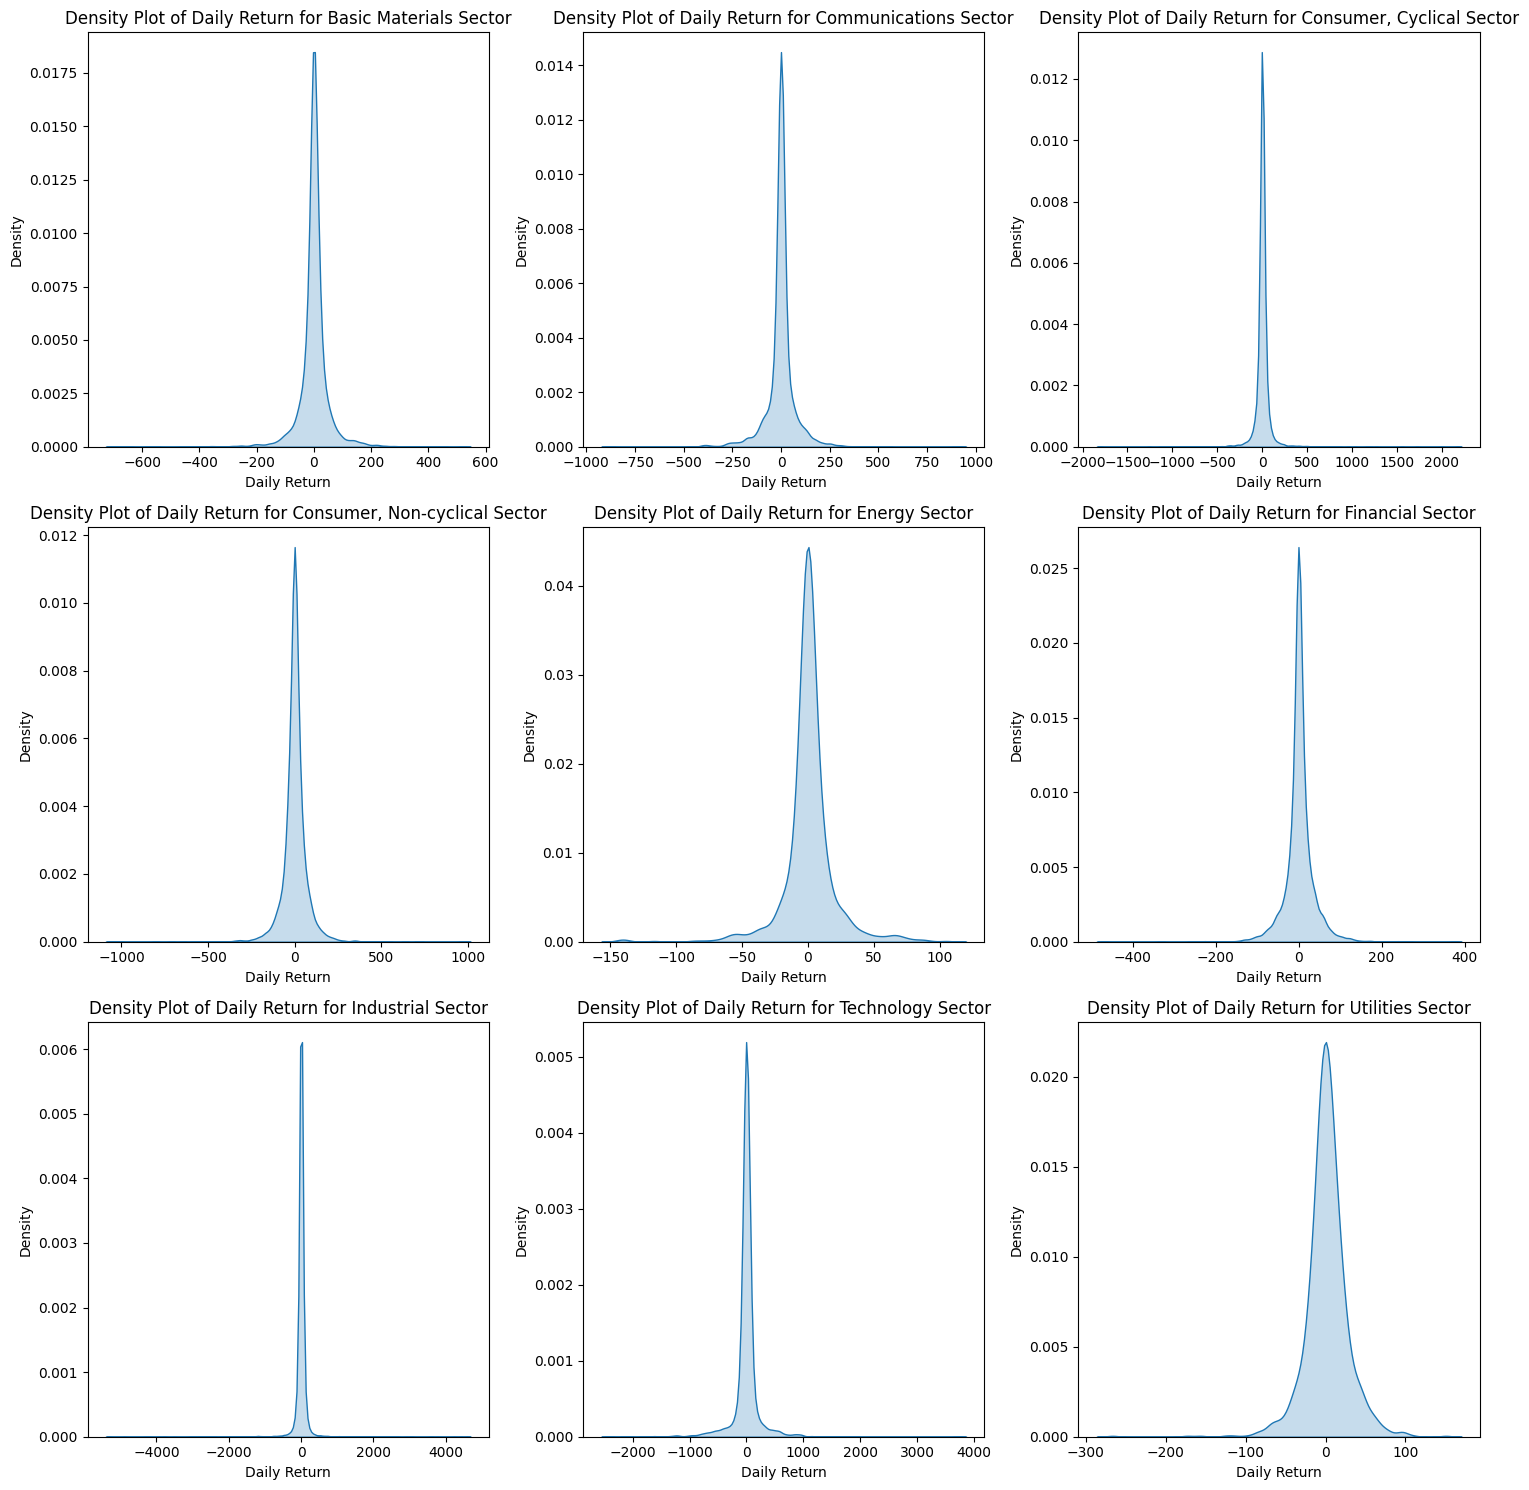

In [116]:
# Select the data of 2022
full_2022 = full[full["date"] >= "2022-01-01"]
full_2022 = full_2022[full_2022["date"] <= "2022-12-31"]

# plot the density plot of daily return for each sector
full_2022_groupBy_sector = full_2022.groupby("bics_sector")
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for (name, group), ax in zip(full_2022_groupBy_sector, axs.flatten()):
    mean = group["diff"].sum() / int(group["diff"].count())
    print("Mean of Daily Return for Sector ", name, ": ", mean, sep="")
    sns.kdeplot(group["diff"], shade=True, ax=ax)
    ax.set_title(f'Density Plot of Daily Return for {name} Sector')
    ax.set_xlabel('Daily Return')
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()